# Support points with Exponential Mechanism

### Procedure:


1. Given data $X = \{x_1, \ldots, x_m\}$ on space $\mathcal{D} \in [0, 1]^d$, find optimal support points $Y = \{y_1, \ldots, y_n\}$.
2. Using energy distance (with Lp norm) as the score function of the exponential mechanism, the sensitivity is $\Delta u = \frac{2 d^{\frac{1}{p}}}{n^2}$. The exponential mechanism samples a new energy value $\tilde{e} \sim \mbox{Lap}(\frac{2S}{\epsilon})$, where $\epsilon$ is the privacy budget.
3. Let $\tilde{Y}$ be a copy of $Y$. While $e(\tilde{Y}, Y) < \tilde{e}$, perturb all points in $\tilde{Y}$ with small step in a random direction.


_____

# 0. Helper Functions

In [1]:
%matplotlib inline

import sys
print(sys.version)
import math
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
import os
import pdb
import sys
import time
import tensorflow as tf
print(tf.__version__)

from sp_utils import (
    get_support_points,
    energy,
    sample_sp_exp_mech,
    mixture_model_likelihood,
    sample_full_set_by_diffusion)

3.7.1 (default, Nov 28 2018, 11:55:14) 
[Clang 9.0.0 (clang-900.0.39.2)]
1.13.1


____

# 1. Global Config

In [2]:
# Set global constants.          # main1()
IS_TF = True                     # Boolean. Use TensorFlow rather than analytical gradients.
Y_INIT_OPTION = 'radial'         # ['grid', 'random', 'radial']
DATA_SOURCE = 'balog'            # ['balog', 'gaussian', 'gamma', 'beta']
MAX_ITER = 301                   # Num iterations in each support point optimization. [301]
LR = 0.01                        # Energy optimization learning rate. [1e-2]

ENERGY_POWER = 2.                # Power for energy distance kernel.
ALPHA = 1                        # Differential privacy level.
M = 200                          # Number of data points.
N = 20                           # Number of support points.
DIM = 2                          # Dimension of data.
STEP_SIZE = 5e-4                 # Diffusion and MH step sizes.
NUM_Y_TILDES = 500               # Number of samples of support points.

___

# 2. Load and Plot Data

In [3]:
if DATA_SOURCE == 'balog':
    os.system('python data.py {} {}'.format(M, DIM))
    
    # Note that Balog's N is our M.
    DATA_PATH = '../data/mixture_of_Gaussians_N{}_D{}.npz'. format(M, DIM)

Loaded M=200 data points with dimension DIM=2


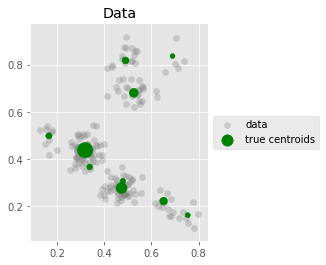

In [4]:
# Load data.
if DATA_SOURCE == 'balog':
    data = np.load(DATA_PATH)
    x = data['X_private']
    mus = data['MUS']
    weights = data['WEIGHTS']
    sigma_data = data['SIGMA_DATA']
    assert (M, DIM) == np.shape(x), 'Balog data dims do not match global params.'
    print('Loaded M={} data points with dimension DIM={}'.format(M, DIM))
    plt.scatter(x[:, 0], x[:, 1], c="gray", alpha=0.3,
                label='data')
    plt.scatter(mus[:, 0], mus[:, 1], c='green', alpha=1, s=700*weights,
                label='true centroids')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Data')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

___

# 3. Run Support Point Optimization


  [*] Using TensorFlow optimization.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
  [*] Overall it/s: 0.0086


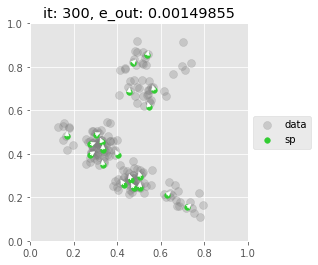

In [5]:
# Compute m support points on full set.
y_opt, e_opt = get_support_points(x, N, MAX_ITER, LR, is_tf=IS_TF)

___

# 4. Define sensitivity.

In [6]:
# Define energy sensitivity for Exponential Mechanism.
energy_sensitivity = 2 * DIM ** (1. / ENERGY_POWER) / N ** 2
print(('Laplace(2 * U / alpha) = Laplace(2 * {:.4f} / {:.2f}) '
       '= Laplace({:.3f})').format(energy_sensitivity, ALPHA, 
                                   2. * energy_sensitivity / ALPHA))

Laplace(2 * U / alpha) = Laplace(2 * 0.0071 / 1.00) = Laplace(0.014)


___

# 5. Sample support points.



--------- RUNNING DIFFUSION ----------


Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.0071 / 1) = Exp(0.0141)

Diffusion count   380, e_opt:  0.001499, e~: 0.005202, energy(y,y~): 0.005206, error%: 0.000752


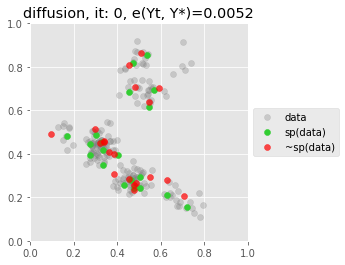

In [7]:
# Sampling parameters.
STEP_SIZE = 2e-3
NUM_Y_TILDES = 1

RUN_MH = 0
RUN_DIFFUSION = 1
PLOT = 0

if RUN_MH:
    METHOD = 'mh'
    print('\n\n--------- RUNNING {} ----------\n'.format(METHOD.upper()))
    (y_tildes_mh,
     energies_mh) = sample_sp_exp_mech(e_opt, energy_sensitivity, x, y_opt,
                                       METHOD, STEP_SIZE, NUM_Y_TILDES, 
                                       alpha=ALPHA)

if RUN_DIFFUSION:
    METHOD = 'diffusion'
    print('\n\n--------- RUNNING {} ----------\n'.format(METHOD.upper()))
    (y_tildes_diffusion,
     energies_diffusion) = sample_sp_exp_mech(e_opt, energy_sensitivity, x, y_opt,
                                              METHOD, STEP_SIZE, NUM_Y_TILDES,
                                              alpha=ALPHA)

In [8]:
# Plot results of sampling for private support points.
if PLOT:
    if RUN_MH:
        plt.title('Energies with MH, n={}'.format(len(energies_mh)))
        plt.hist(energies_mh, bins=20, alpha=0.3)
        plt.show()

    if RUN_DIFFUSION:
        plt.title('Energies with Diffusion, n={}'.format(len(energies_diffusion)))
        plt.hist(energies_diffusion, bins=20, alpha=0.3)
        plt.show()

    # Compare to energies of e(y_opt, uniform)
    baseline_energies = np.zeros(NUM_Y_TILDES)
    for i in range(NUM_Y_TILDES):
        e_, _ = energy(y_opt, np.random.uniform(size=y_opt.shape))
        baseline_energies[i] = e_
    plt.title('Energies with UNIFORM, n={}'.format(len(baseline_energies)))
    plt.hist(baseline_energies, bins=20, alpha=0.3)
    plt.show()

___

# 6. Expand to full data set.

### 6.0  Given privately (by diffusion) sampled SP, expand them using KDE and pre-selected bandwidth.


Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.0071 / 1) = Exp(0.0141)

Diffusion count  1555, e_opt:  0.001499, e~: 0.020878, energy(y,y~): 0.020911, error%: 0.001596


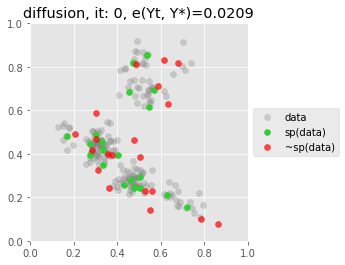

Accuracy of sampled SP, i.e. energy(~y, y_opt): 0.0209


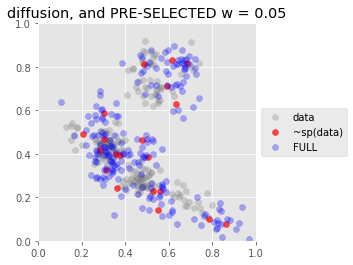

In [59]:
# Show data and y_tilde.
NUM_Y_TILDES = 1
METHOD = 'diffusion'
BANDWIDTH = 0.05
SAMPLE_SIZE = M

(y_tilde,
 y_tilde_upsampled,
 y_tilde_expansion,
 energy_y_y_tilde) = sample_full_set_by_diffusion(e_opt, energy_sensitivity,
                                                  x, y_opt, STEP_SIZE, ALPHA,
                                                  BANDWIDTH, SAMPLE_SIZE)

plt.scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3, label='data')
plt.scatter(y_tilde[:, 0], y_tilde[:, 1], c='red', alpha=0.7, label='~sp(data)')
plt.scatter(y_tilde_expansion[:, 0], y_tilde_expansion[:, 1], c='blue', 
            alpha=0.3, label='FULL')

plt.title('{}, and PRE-SELECTED w = {}'.format(METHOD, BANDWIDTH))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


###  6.1  Show KDE over a range of bandwidths, and compute likelihood for each.

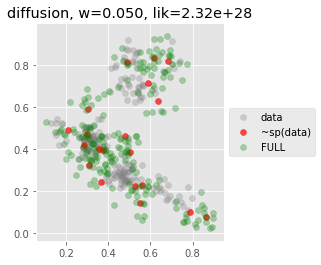

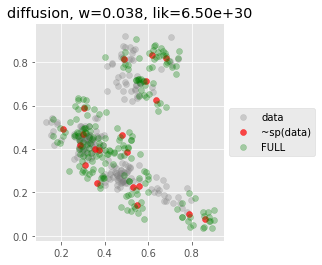

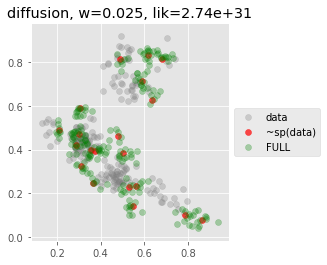

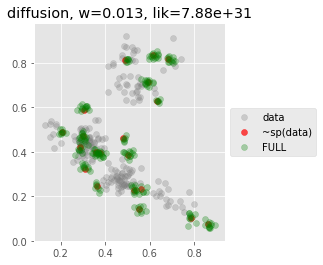

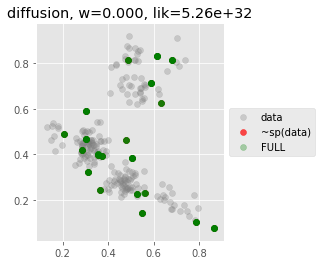

Likelihood of data (x): 9.01e+50
Likelihood of optimal SP (y_opt): 1.50e+05
Likelihood of SP sample, upsampled (y_tilde_up): 5.24e+32

bw: 0.050, lik: 2.32e+28
bw: 0.038, lik: 6.50e+30
bw: 0.025, lik: 2.74e+31
bw: 0.013, lik: 7.88e+31
bw: 0.000, lik: 5.26e+32


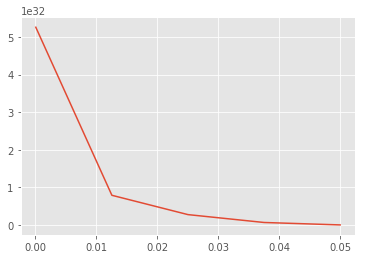

In [64]:
# Find optimal bandwidth using Maximum Likelihood.
NUM_BANDWIDTHS = 5
BW_HIGH, BW_LOW = 0.05, 0.0001
BW_RANGE = np.linspace(BW_HIGH, BW_LOW, NUM_BANDWIDTHS)
PLOT = 1

# Store bandwidth and likelihood pairs.
bw_lik = np.zeros((NUM_BANDWIDTHS, 2))

for i, bw in enumerate(BW_RANGE):    
    new_sample = (
        y_tilde_upsampled + np.random.normal(0, bw,
                                             size=(SAMPLE_SIZE, x.shape[1])))
    
    lik = mixture_model_likelihood(new_sample, mus, weights, sigma_data)
    
    bw_lik[i] = [bw, lik]

    # Plot results.
    if PLOT:
        plt.scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3, label='data')
        #plt.scatter(mus[:, 0], mus[:, 1], c='green', alpha=1, s=700*weights,
        #    label='true centroids')
        plt.scatter(y_tilde[:, 0], y_tilde[:, 1], c='red', alpha=0.7,
                    label='~sp(data)')
        plt.scatter(new_sample[:, 0], new_sample[:, 1], c='green', alpha=0.3,
                    label='FULL')

        plt.title('{}, w={:.3f}, lik={:.2e}'.format('diffusion', bw, lik))
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.gca().set_aspect('equal', adjustable='box')
        plt.show()


# Compare to likelihoods of data and optimal support points.
lik_x = mixture_model_likelihood(x, mus, weights, sigma_data)
lik_y_opt = mixture_model_likelihood(y_opt, mus, weights, sigma_data)
lik_y_tilde_up = mixture_model_likelihood(y_tilde_upsampled, mus, weights, sigma_data)


print('Likelihood of data (x): {:.2e}'.format(lik_x))
print('Likelihood of optimal SP (y_opt): {:.2e}'.format(lik_y_opt))
print('Likelihood of SP sample, upsampled (y_tilde_up): {:.2e}\n'.format(lik_y_tilde_up))
for bw, lik in bw_lik:
    print('bw: {:.3f}, lik: {:.2e}'.format(bw, lik))

plt.plot(bw_lik[:, 0], bw_lik[:, 1])

____

### 6.2. Try repeated draws of private support points, and concatenate results.


Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.0071 / 1) = Exp(0.0141)

Diffusion count   594, e_opt:  0.001499, e~: 0.006008, energy(y,y~): 0.006045, error%: 0.006226


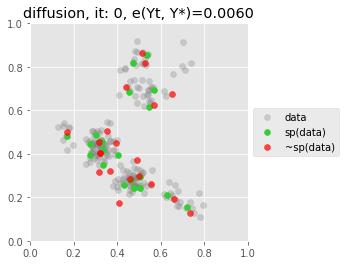


Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.0071 / 1) = Exp(0.0141)

Diffusion count  1720, e_opt:  0.001499, e~: 0.017285, energy(y,y~): 0.017331, error%: 0.002637


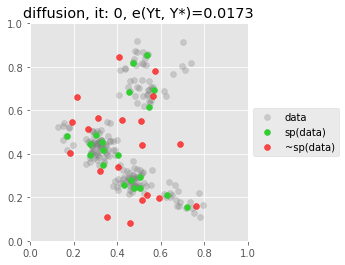


Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.0071 / 1) = Exp(0.0141)

Diffusion count  2941, e_opt:  0.001499, e~: 0.018022, energy(y,y~): 0.018029, error%: 0.000420


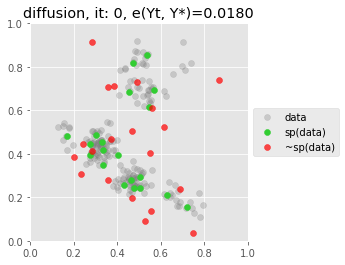


Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.0071 / 1) = Exp(0.0141)

Diffusion count   269, e_opt:  0.001499, e~: 0.006093, energy(y,y~): 0.006185, error%: 0.015098


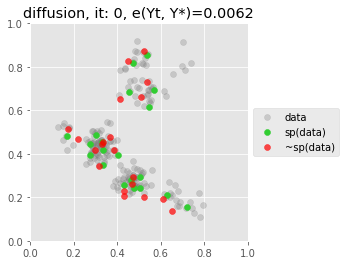


Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.0071 / 1) = Exp(0.0141)

Diffusion count  3070, e_opt:  0.001499, e~: 0.020699, energy(y,y~): 0.020849, error%: 0.007264


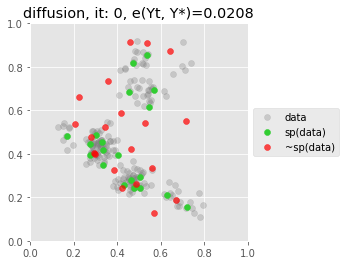


Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.0071 / 1) = Exp(0.0141)

Diffusion count    20, e_opt:  0.001499, e~: 0.001293, energy(y,y~): 0.001416, error%: 0.095280


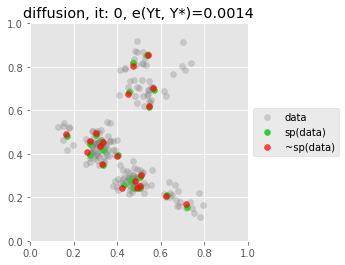


Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.0071 / 1) = Exp(0.0141)

Diffusion count  2952, e_opt:  0.001499, e~: 0.019375, energy(y,y~): 0.019385, error%: 0.000483


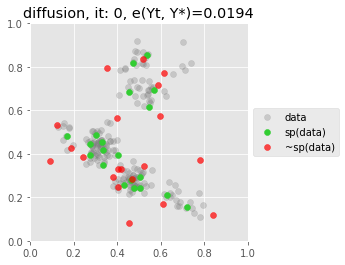


Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.0071 / 1) = Exp(0.0141)

Diffusion count  1360, e_opt:  0.001499, e~: 0.017134, energy(y,y~): 0.017398, error%: 0.015423


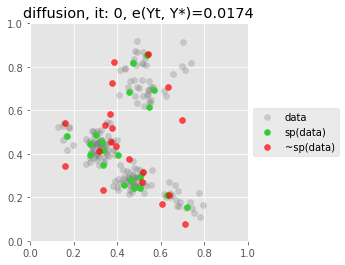


Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.0071 / 1) = Exp(0.0141)

Diffusion count   541, e_opt:  0.001499, e~: 0.009455, energy(y,y~): 0.009612, error%: 0.016587


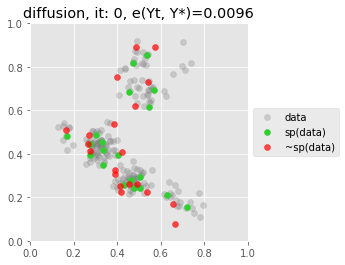


Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.0071 / 1) = Exp(0.0141)

Diffusion count   429, e_opt:  0.001499, e~: 0.007756, energy(y,y~): 0.007982, error%: 0.029074


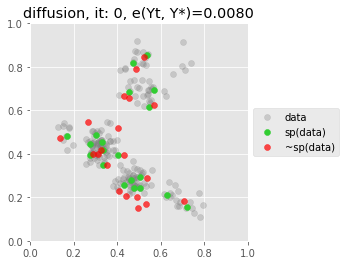


Concatenating results, and plotting collection of samples as one.



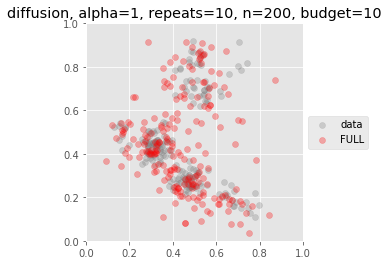

In [69]:
NUM_REPEATS = 10
new_sample = []

for i in range(NUM_REPEATS):
    (y_tilde,
     y_tilde_upsampled,
     y_tilde_expansion,
     energy_y_y_tilde) = sample_full_set_by_diffusion(e_opt, energy_sensitivity,
                                                      x, y_opt, STEP_SIZE, ALPHA,
                                                      BANDWIDTH, SAMPLE_SIZE)
    new_sample.append(y_tilde)

print('\nConcatenating results, and plotting collection of samples as one.\n')

new_sample = np.concatenate(new_sample)

plt.scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3, label='data')
# plt.scatter(y_tilde[:, 0], y_tilde[:, 1], c='red', alpha=0.7, label='~sp(data)')
plt.scatter(new_sample[:, 0], new_sample[:, 1], c='red', alpha=0.3, label='FULL')

plt.title('{}, alpha={}, repeats={}, n={}, budget={}'.format(
    METHOD, ALPHA, NUM_REPEATS, len(new_sample), ALPHA * NUM_REPEATS))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# End.